## Karate club network
#### Karate club network is a popular and much-used social network collected from the members of a university karate club by Wayne Zachary in 1977. Members in the club gradually split into two groups due to a conflict between the instructor “Mr. Hi” and the president “John A”. Half of the members formed a new club around the “Mr. Hi”, others found a new instructor or gave up karate. The dataset contains 34 nodes representing members of the club among which node 1 represent the instructor and node 34 the president, an edge is placed if there are interactions between two members.
##### Please cite W. W. Zachary, An information flow model for conflict and fission in small groups, Journal of Anthropological Research 33, 452-473 (1977).

### Apply GN algorithm on karate club network
#### This function is recursive as it tries to find an optimal way of cutting the graph into two pieces, and then it does the same on the pieces.  It terminates when it is given a graph with only one node. It returns a list of all the components it has found:

In [178]:
import community
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
kn = nx.karate_club_graph()

In [7]:
#def of Girvan-Newman
import networkx as nx
import math
from collections import defaultdict,Counter
def girvan_newman (G, print_biggest = False, max_d=None,min_size=None,min_component_ratio=.1,
                   create_partition=False,relabel_partition_flag=False):
    """
    A very simple no bells and whistles implementation of
    girvan-newman, relying on networkx.


    Returns a C{components_dict}.  This is a dictionary with form
    C{component_id} => (C{c1}, C{c2}) where C{component_id} is the string id of
    a graph component, and C{c1} and C{c2} are the
    two subcomponents of C{component_id}, represented as node lists.
    String ids are assigned according to the following convention:
    The string id of C{c1} is C{component_id} +'0' and the  string_id
    of C{c2} is C{component_id} + '1'.  The string id of the largest connected
    component of C{G} is '0'.  Thus the longer a string id, the more deeply
    embedded if is in Girvan-Newman's recursive computation.  We order
    C{c1} and C{2} in the pair (C{c1},C{c2}) so that len(C{c1}) > len(C{c2}).

    Since this destroys the graph, we make a copy of the graph
    at the top level, using::

       G.copy()


    """
    G = G.copy()
    components_dict = defaultdict(list)
               
    index = '0'


    big_component = max(nx.connected_component_subgraphs(G),key=lambda x: len(x.nodes()))
    bg_len = len(big_component.nodes())
    if min_size is None:
        min_size = math.floor(min_component_ratio * bg_len)

    print('G size: %d Max component size: %d min splittable size: %d' % (len(G.nodes()),bg_len,min_size))

    girvan_newman_helper(big_component, print_biggest = print_biggest, index = '0',
                         max_d = max_d, components_dict=components_dict,min_size=min_size,
                         create_partition=create_partition)
    print('Creating partition: %s' % create_partition)
    if create_partition:
        #return partition_components_dict(G,components_dict,min_partition_size=min_size)
        partition =  partition_components_dict(G,components_dict)
        ps = set(partition.values())
        print('Partitions found',)
        print(ps)
        if relabel_partition_flag:
            partition = relabel_partition(G, partition)
        return partition
    else:
        return components_dict


def girvan_newman_helper (G, print_biggest = False, index='0',
                          max_d=None,components_dict=None,min_size=100,
                          create_partition=False):
    
    # print 'index: %s (%d nodes) => ' % (index,len(G.nodes())),

    if len(G.nodes()) == 1:
        components_dict[index].append(G.nodes())
        return components_dict
    
    def find_best_edge(G0):
        """
        Networkx implementation of edge_betweenness
        returns a dictionary. Make this into a list,
        sort it and return the edge with hoghest betweenness.
        """
        eb = nx.edge_betweenness_centrality(G0)
        eb_il = list(eb.items())
        eb_il.sort(key=lambda x: x[1], reverse=True)
        return eb_il[0][0]

    components = list(nx.connected_component_subgraphs(G))
    
    while len(components) == 1:
        G.remove_edge(*find_best_edge(G))
        components = list(nx.connected_component_subgraphs(G))

    # for later, put big component first.
    
    components.sort(key=lambda x: len(x.nodes()),reverse=True)
    for c in components:
        print('%d nodes' % (len(c.nodes()),),)
    #print

    for c in components:
        components_dict[index].append(tuple(c.nodes()))
    if print_biggest:
        for c in components_dict[index]:
            print(c)
    if (max_d is None) or (len(index) < max_d):
        ctr = 0
        for c in components:
            if len(c.nodes()) > min_size:
                girvan_newman_helper(c,index='%s%d' % (index,ctr),
                                     max_d=max_d,components_dict=components_dict,min_size=min_size)
            ctr += 1
    return components_dict

def relabel_partition (G, partition):
    new_partition = dict()
    nds_dict = dict(G.nodes(data=True))
    for (k,v) in partition.iteritems():
        new_partition[nds_dict[k]['label']] = v
    return new_partition
    

def find_big_splits  (components_dict):
    """
    Assumes Girvan Newman (GN) has been run with a min_size val that excludes
    components of very small size, so that all splits are of interest.  Also
    assumes the components dict GN produces has the structure cluster_id => (c1,c2),
    where len(c2) > len(c1).

    Then just sorts the list of splits by the size ratio (if c splits as c1,c2, then c1/c2), and
    returns that sorted list.  First thing on it shd be the best "interesting component" split

    """
    def get_ratio (entry):
        try:
            (index, (c1,c2)) = entry
        except:
            return 0
        return float(len(c1))/len(c2)
    components_dict_il = components_dict.items()
    rl = [(get_ratio(x),x[0],len(x[1][0]),len(x[1][1])) for x in components_dict_il if len(x[1]) == 2]
    return sorted(rl)


def old_find_big_split  (components_dict, ratio_limit=1.6,min_diameter=0):
    global component_size,victors
    assert ratio_limit > 1, 'Must use a ratio limit greater  than 1'
    ratio_limit_inverse = 1/ratio_limit
    components_dict_il = components_dict.items()
    components_dict_il.sort(key=lambda x: len(x[0]))
    
    #size = len(G.nodes())
    big_components = components_dict['0']
    size = len(big_components[0]) + len(big_components[1])
    depth = 1
    target_split_diameter = size
    component_size = {'0':size}
    victors = set()
    # Put larger component first in each partition.
    while (target_split_diameter > min_diameter) and not victors:
        # Extract all victors meeting ratio requirement and bigger
        # than target_split_diameter on this round of while loop.
        # If none found we'll try again with reduced target_split_diameter
        best_split_diameter = 0
        for entry in components_dict_il:
            print('for1: ', target_split_diameter, best_split_diameter, depth)
            try:
                (index,(c1,c2)) = entry
            except ValueError:
                continue
            print(index)
            if len(index) > depth:
                if 0 < best_split_diameter < target_split_diameter:
                    ## It keeps getting smaller from here
                    ## so give up and reduce target
                    break
                if victors:
                    break
                depth = len(index)
                best_split_diameter = 0

            if component_size[index] > best_split_diameter:
                best_split_diameter = component_size[index]

            ## Record component sizes of compnents for future ref
            c1_len, c2_len = (len(c1),len(c2))
            component_size[index + '0'] = c1_len
            component_size[index + '1'] = c2_len
            
            if component_size[index] >= target_split_diameter:
                this_ratio = float(c1_len)/c2_len
                if (ratio_limit > this_ratio):
                    victors.add((c1,c2))
               
                
        target_split_diameter -= 1
    return argmax (victors)

    
def argmax (victors):
    if len(victors) > 1:
        f = lambda x: max(len(x[0]),len(x[1]))
        return max(victors,key = lambda x: f(x))
    else:
        return victors


def get_cluster_purity (G, clusters, class_att):
    """
    C{clusters} is a list of node lists, each representing
    a cluster in the original graph C{G}. C{class_att} is the classifying attribute
    of interest, which must be a key in  all the node dicts for nodes in graph C{G}.

    Returns C{purity_list}: C{purity_list[component_index]} => (value, purity_score,size)
    For each cluster ci in clusters, return a triple of (i) the value of C{class_att}
    held by majority of members of ci; (ii) percentage of members of ci having that value;
    and (iii) size of ci.
    """
    node_dict = dict(G.nodes(data=True))
    purity_list = []
    for (i,clust) in enumerate(clusters):
        att_dict = Counter()
        size = len(clust)
        for n in clust:
            att_dict[node_dict[n][class_att]] += 1
        (winning_class,winning_class_ct) = att_dict.most_common()[0]
        purity_list.append((winning_class,float(winning_class_ct)/size,size))
    return purity_list


def partition_components_dict(G,components_dict,min_partition_size=2):
    """
    This is not yet right.

    Let's say we know when to say cluster c_k has significant components c1,c2
    based on some correct definition of C{passes_test} below.

    We still need a criterion for when we can replace c1,c2, or both
    by THEIR components.  So if it's both, then part_dict[c_k] = union(parts_dict[c1],parts_dict[c2]).

    Just saying whenEVER c2 or c2 have components always favors smaller components.
    Saying NEVER always favors smaller components.

    Let's c_k is a significant component of c_m.
    When are c_k's componets, c1,c2,...cn (size_sorted) a good replacement for ck as components of c_m.
    One answer:
    
    passes_test(size_dict[c_n],len(c_m),N,min_partition_size)

    We may pass the test, but why would c1,...cn be a better answer than c_k,
    which is BIGGER?  It cant be information loss.  BY our current criteria
    it can only be because c_k is still too big, and is better broken up.
    But this function call cant apply that criterion...

    """
    print('Calling partition_components')
    N = len(G.nodes())
    components_dict = components_dict.copy()
    components_dict_il = components_dict.items()
    size_dict = dict()
    for entry in components_dict_il:
        try:
            (k,(c1,c2))  = entry
        except:
            continue
        size_dict[k] = len(c1) + len(c2)
    components_dict_il = [(k, (c1,c2)) for (k, (c1,c2)) in components_dict_il if k in size_dict]
    components_dict_il.sort(key=lambda x: size_dict[x[0]],reverse=True)
    #print len(size_dict), len(components_dict_il), len(components_dict)

    def passes_test(c_size,M,N,min_partition_size,r):
        """
        This is not yet right.
        :"""
        if  c_size < min_partition_size or r > 6.0:
            return False
        else:
            return True
        #  None of the other criteria detailed below are beiung used yet.
        #  M Not too big relative to N and cluster not too small relative to M
        test = M < (.8 * N) and  r <= 9.0 # 1.6
        if test:
            return True
        elif  M < (.8 * N):
            # M  not too big.
            return r < 2.0
        elif r < 8:
            # M is too big. split it.
            return True
        else:
            return False

    # parts_dict the topdown correspondent to the partition_dict
    # Start with every node assigned to an "other" partition
    parts_dict,partition_dict = (defaultdict(list),dict(zip(G.nodes(),N*['1'])))
    for (k, (c1,c2)) in components_dict_il:
        parts_dict[k] = [c1,c2]
        c1_len,c2_len = (len(c1),len(c2))
        #print len(c2), size_dict[k],N,min_partition_size,c1_len,c2_len
        if passes_test(len(c2),size_dict[k],N,min_partition_size,float(c1_len)/c2_len):
            update_partition_dict(k,(c1,c2),parts_dict,partition_dict)
        #elif c1 in parts_dict:
        #    if test_cluster_parts(k,size_dict[k],N, [c1,c2],partition_dict,parts_dict,components_dict,size_dict):
        #        update_partition_dict(k,size_dict[k],N,parts_dict[c1],
        #                              partition_dict,parts_dict,components_dict,size_dict)
    return partition_dict

    
def update_partition_dict (k,component_nodes,parts_dict,partition_dict):
    #for (i,c) in enumerate(components):
    for i in range(len(component_nodes)):
        parts_dict[k].append('%s%d' % (k,i))
        for n in component_nodes[i]:
            partition_dict[n] = k


In [11]:
if __name__ == '__main__':

    import os.path
    os.chdir('/Users/kate')
    to_do = 'zachary'

if to_do == 'zachary':
        kn = nx.karate_club_graph()
        z_components_dict = girvan_newman(kn, print_biggest=False)
        z_ratio_list  = find_big_splits(z_components_dict)
        # For Zachary's karate the interesting split is the top split '0', which comes second on the ratio list
        (z_ratio, z_winner, z_len1, z_len2) = z_ratio_list[1]
        # The Officer cluster only has purity 89.5%, while the Mr. Hi faction has purity 100%
        # There are 2 Mr. Hi nodes tangled up among the others.
        z_purity = get_cluster_purity(kn,z_components_dict[z_winner],'club')
        # Going one level deeper doesnt help. An officer node is split off, not a Mr. Hi node as one might hope.
        z_purity2 = get_cluster_purity(kn,z_components_dict[z_winner+'0'],'club')
        # Going one level further doesnt help either. We get two substantial sub factions,
        # each with one Mr. Hi node.
        z_purity3 = get_cluster_purity(kn,z_components_dict[z_winner+'00'],'club')


G size: 34 Max component size: 34 min splittable size: 3
19 nodes
15 nodes
18 nodes
1 nodes
12 nodes
6 nodes
11 nodes
1 nodes
10 nodes
1 nodes
9 nodes
1 nodes
8 nodes
1 nodes
7 nodes
1 nodes
6 nodes
1 nodes
5 nodes
1 nodes
4 nodes
1 nodes
3 nodes
1 nodes
3 nodes
3 nodes
10 nodes
5 nodes
9 nodes
1 nodes
8 nodes
1 nodes
7 nodes
1 nodes
6 nodes
1 nodes
5 nodes
1 nodes
4 nodes
1 nodes
3 nodes
1 nodes
3 nodes
2 nodes
Creating partition: False


In [9]:
kn.node[0]

{'club': 'Mr. Hi'}

#### dendrogram can describe the process:
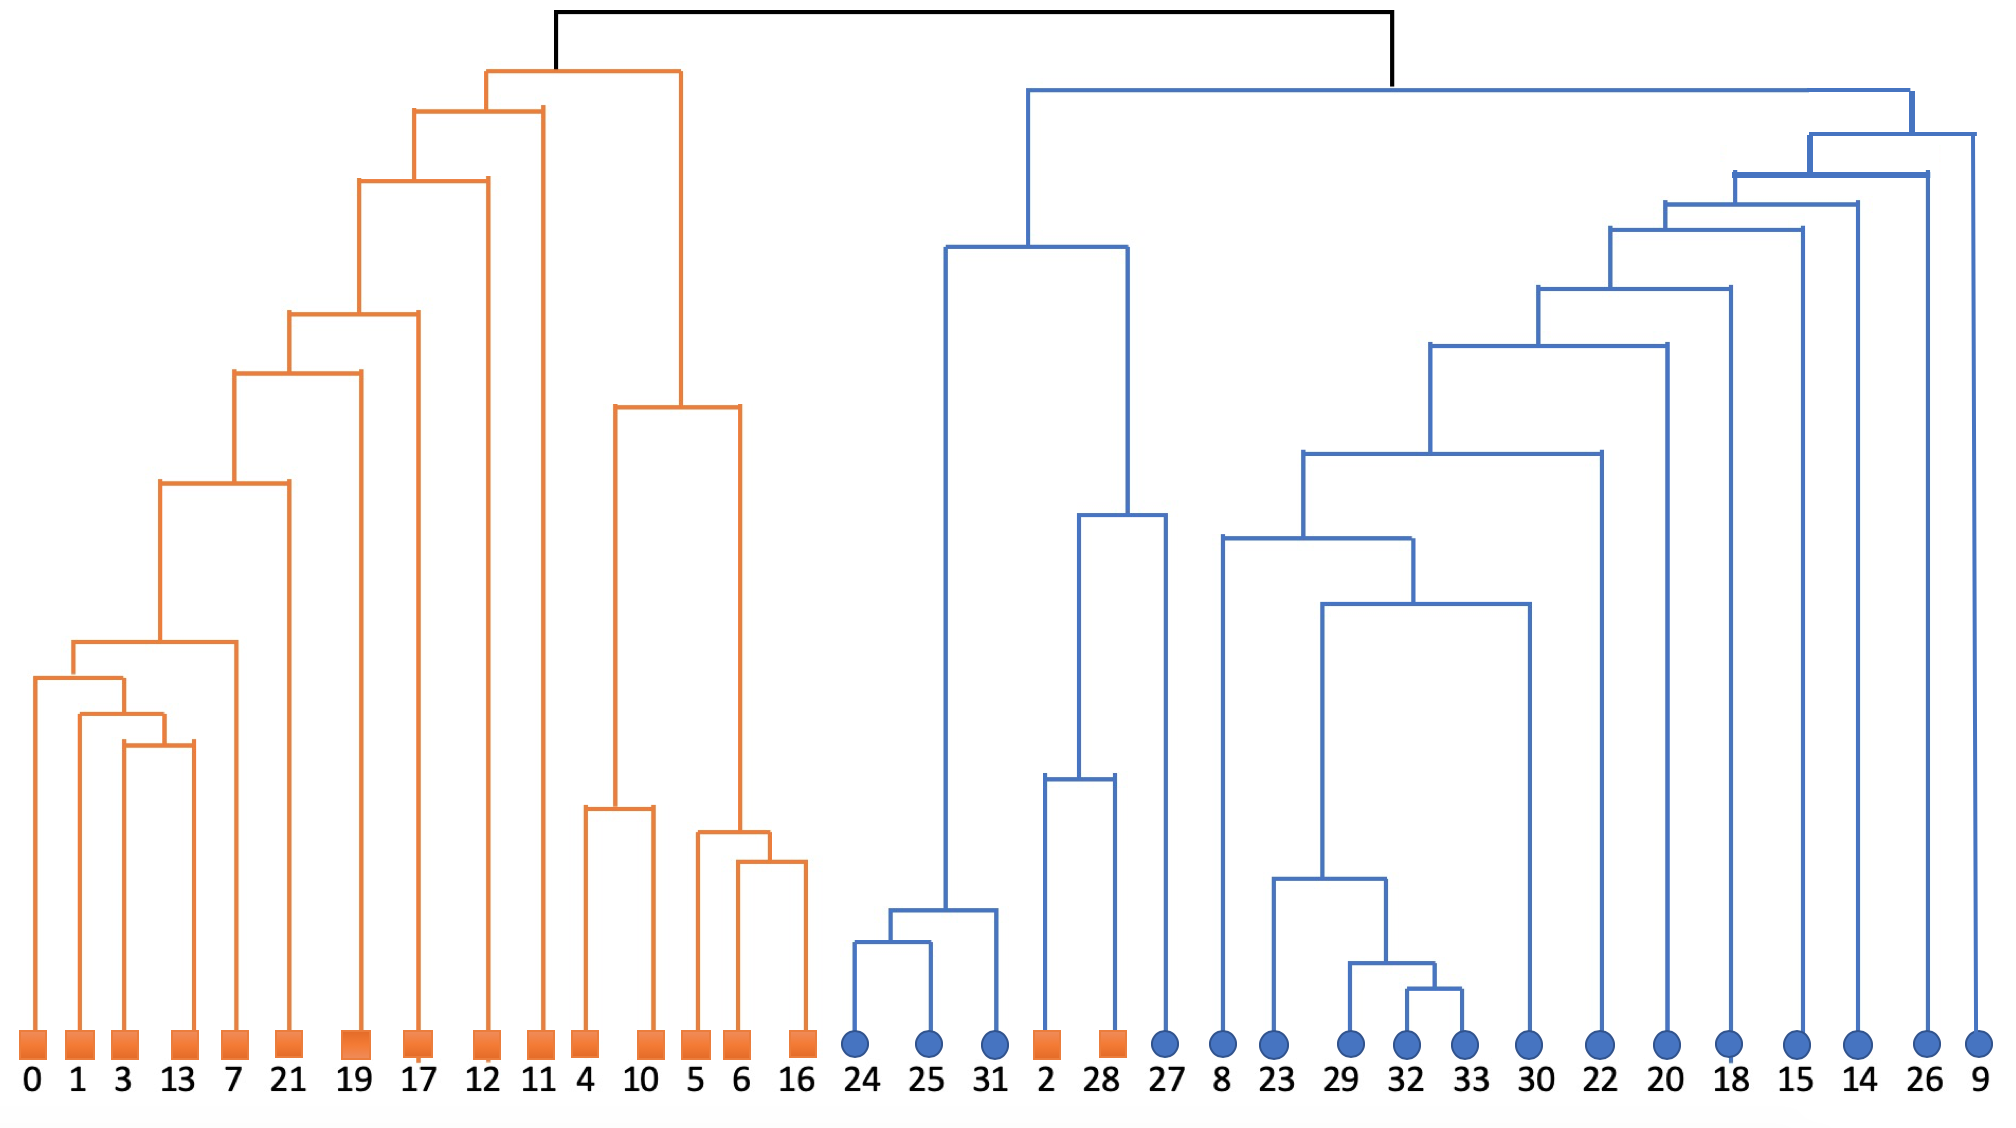

In [152]:
print(z_components_dict)

defaultdict(<class 'list'>, {'0': [(2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33), (0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21)], '00': [(2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33), (9,)], '000': [(8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33), (2, 24, 25, 27, 28, 31)], '0000': [(8, 14, 15, 18, 20, 22, 23, 29, 30, 32, 33), (26,)], '00000': [(8, 15, 18, 20, 22, 23, 29, 30, 32, 33), (14,)], '000000': [(8, 18, 20, 22, 23, 29, 30, 32, 33), (15,)], '0000000': [(8, 20, 22, 23, 29, 30, 32, 33), (18,)], '00000000': [(8, 22, 23, 29, 30, 32, 33), (20,)], '000000000': [(8, 23, 29, 30, 32, 33), (22,)], '0000000000': [(23, 29, 30, 32, 33), (8,)], '00000000000': [(23, 29, 32, 33), (30,)], '000000000000': [(29, 32, 33), (23,)], '0001': [(2, 27, 28), (24, 25, 31)], '01': [(0, 1, 3, 7, 11, 12, 13, 17, 19, 21), (4, 5, 6, 10, 16)], '010': [(0, 1, 3, 7, 12, 13, 17, 19, 21), (11,)], '0100': [(0, 1, 3, 7, 13, 17, 19, 21), (12,)], '01000': [(0, 

In [14]:
z_ratio_list
#z_purity          ##[('Officer', 0.8947368421052632, 19), ('Mr. Hi', 1.0, 15)]
#z_purity2        ##[('Officer', 0.8888888888888888, 18), ('Officer', 1.0, 1)]
#z_purity3        ##[('Officer', 0.9166666666666666, 12), ('Officer', 0.8333333333333334, 6)]   

[(1.0, '0001', 3, 3),
 (1.2666666666666666, '0', 19, 15),
 (1.5, '011', 3, 2),
 (2.0, '000', 12, 6),
 (2.0, '01', 10, 5),
 (3.0, '000000000000', 3, 1),
 (3.0, '010000000', 3, 1),
 (4.0, '00000000000', 4, 1),
 (4.0, '01000000', 4, 1),
 (5.0, '0000000000', 5, 1),
 (5.0, '0100000', 5, 1),
 (6.0, '000000000', 6, 1),
 (6.0, '010000', 6, 1),
 (7.0, '00000000', 7, 1),
 (7.0, '01000', 7, 1),
 (8.0, '0000000', 8, 1),
 (8.0, '0100', 8, 1),
 (9.0, '000000', 9, 1),
 (9.0, '010', 9, 1),
 (10.0, '00000', 10, 1),
 (11.0, '0000', 11, 1),
 (18.0, '00', 18, 1)]

#### As we seen, "z_components_dict" stores the communities detected by Girvan-Newman algorithm hierachically. More specifically, (better draw a graph to show clearly) at first GN split the 34 karete club members into two groups (one are mostly members in "officer club" with 19 people and the other "Hi club" with 15). We caluculate the purity of the two, the "officer" has purity 89.5% and "Hi" has purity 100%, meaning that there are two members are misclassified (should be in "Hi" but be classified into "Office"). Then, we tried a further level of GN algorithm and calculated the purity but no satisfying results. For this reason, we prefer to extract two communities among 34 members.

In [173]:
#partition given by GN algorithm when community number is two:
partition_kn={0: 3,1: 3,2: 4,3: 3,4: 3,5: 3,6: 3,7: 3,8: 4,9: 4,10: 3,11: 3,12: 3,13: 3,14: 4,15: 4,16: 3,17: 3,
 18: 4,19: 3,20: 4,21: 3,22: 4,23: 4,24: 4,25: 4,26: 4,27: 4,28: 4,29: 4,30: 4,31: 4,32: 4,33: 4}

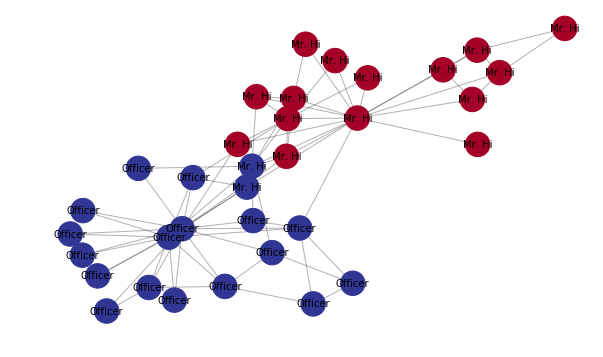

In [176]:
#visualize the detected communities by GN algorithm
import community
newlabels1 = dict((x,node_dict[x]['club']) for x in G_karate.nodes())

G_karate = nx.karate_club_graph()
partition = partition_kn
pos = nx.spring_layout(G_karate)
plt.figure(figsize=(10, 6))
plt.axis('off')
nx.draw_networkx_nodes(G_karate, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G_karate, pos, alpha=0.3)
nx.draw_networkx_labels(G_karate,pos,newlabels1,font_size=10,font_color='black')
plt.show(G_karate)

### Thus, Girvan-Newman algorithm divides the network into two communities with only two people be misclassified, expressing the well perform of Girvan-Newman algorithm on such simple and small-size network.
### It is also worth mentioning that here we identified the stop point of the GN algorithm and then obtained the number of communities by calculating the purity of detected communities. However, a criteria should be involved to make the detection process more accurate and efficient. 
### Louvain method detected communities based on maximizing the modularity. Modularity measures the performance of the clustering and large modularity value refers to a reasonable partition. Inspired by this, Louvain could detect the community structure by maximizing the modularity with high accurate and fast speed.

# Apply Louvain method on Karate club network

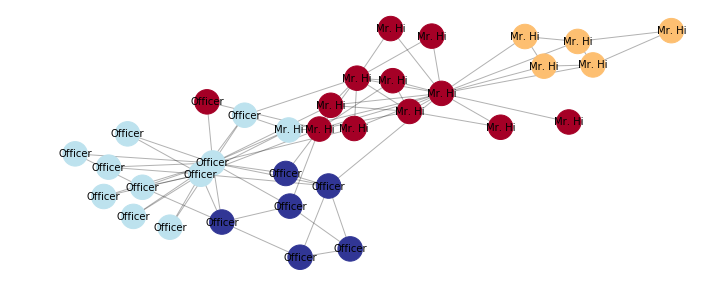

In [141]:
import community
newlabels1 = dict((x,node_dict[x]['club']) for x in G_karate.nodes())

G_karate = nx.karate_club_graph()
partition = community.best_partition(G_karate)
pos = nx.spring_layout(G_karate)
plt.figure(figsize=(12, 5))
plt.axis('off')
nx.draw_networkx_nodes(G_karate, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G_karate, pos, alpha=0.3)
nx.draw_networkx_labels(G_karate,pos,newlabels1,font_size=10,font_color='black')
plt.show(G_karate)

#### We draw different color according to the partition given by Louvain method. And with the nodes labeled with their true club belongings (known as the ground-truth) we can have a clear visualization.

#### Conclusion: As it can be seen that Louvain successfully split the karate club network into 4 communities, two of which are nearly all agree with Mr.Hi club while other two are nearly all agree with Officer club. Note that only two nodes are misclassified which we labeled as node 10 and node 13. Thus, the reasonable of Louvain method is clear, and the fact of it resulting 4 groups may suggest some potential subdivisions.

#### By comparision, both the GN algorithm and Louvain algorithm recovery the most members' club community with same two people be misclassified. With a deeper community detection, both two algorithms show 4 groups shown by following figure (partition and purity), for this reason we can see Louvain is slightly better than GN.